# EDA on underreporting vs actual crime and PAS measures

---

In [1]:
import sys

import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
# from scipy.stats import pearsonr
import datetime as dt

In [2]:
# removes SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [14]:
# load data with preprocessing
try:
    df = pd.read_pickle(r"data/PAS_underreporting.pkl")
except FileNotFoundError:
    print('File "PAS_underreporting.pkl" does not exist. Please run crime_underreporting.ipynb')
    sys.exit(1)
df = df[df["Question"] != 'XQ59CD']  # removing unnecessary question
df = df.replace({'-': np.nan, ' ': np.nan, '': np.nan, '#N/A': np.nan, "Westminster": "City of Westminster"})  # make unknown NAN
df = df.dropna()

### Notes for the PAS underreporting dataset

Only questions **BQ90D** and **BQ90DA** make sense to ask and were asked from 2015 to the beginning of 2021. We will only look at them for plotting. 

This dataset shows underreporting by ward. Most ``no_counts`` were 4 and most ``total_counts`` were 18. There is an additional column ``Total_no_prop`` to show how much a ward contributed to overall underreporting in that quartile for the entire London.

Not all boroughs are listed. 66 entries do not have a borough listed => _dropped rows_.

In [4]:
# Print simple statistics
print(df.shape)
print(df.describe())
print(df.head(20))
print(df.columns)

for col in df.columns:
    print(col)
    print(df[col].unique())
    print(len(df[col].unique()))
    print("---------------------------------------------------------------")

(6861, 8)
       total_count     no_count  Proportion_no  Total_prop_no
count  6861.000000  6861.000000    6861.000000    6861.000000
mean      1.305786     0.394112       0.297666       0.000043
std       0.609983     0.564024       0.426017       0.000062
min       1.000000     0.000000       0.000000       0.000000
25%       1.000000     0.000000       0.000000       0.000000
50%       1.000000     0.000000       0.000000       0.000000
75%       1.000000     1.000000       0.666667       0.000110
max       6.000000     3.000000       1.000000       0.000329
    Year-Month               Borough                            ward_n  \
0   2015-04-01  Barking and Dagenham                         Becontree   
1   2015-04-01  Barking and Dagenham                          Eastbury   
2   2015-04-01  Barking and Dagenham                             Heath   
3   2015-04-01  Barking and Dagenham                          Parsloes   
4   2015-04-01                Barnet                         B

In [5]:
# How often does each borough show up here?
print(df["Borough"].value_counts().sort_values(ascending=False))

Borough
Hackney                   258
Enfield                   244
Camden                    240
Lewisham                  239
Richmond upon Thames      237
Hounslow                  236
Waltham Forest            233
Haringey                  232
Barnet                    228
Islington                 227
Brent                     224
Merton                    223
Kingston upon Thames      217
Redbridge                 216
Southwark                 214
Hillingdon                213
Lambeth                   212
Wandsworth                212
Ealing                    212
Harrow                    211
Tower Hamlets             208
Hammersmith and Fulham    205
Sutton                    203
Croydon                   200
Newham                    196
Bexley                    194
Bromley                   193
City of Westminster       193
Greenwich                 193
Kensington and Chelsea    185
Barking and Dagenham      183
Havering                  180
Name: count, dtype: int64


In [6]:
# DF underreporting by borough + print stats
df_ub = df.groupby(["Year-Month", "Borough"])[["total_count", "no_count", "Total_prop_no"]].sum().reset_index()
print(df_ub.describe())
print("total_count:", sum(df_ub["total_count"]), "\nno_count:", sum(df_ub["no_count"]), "\nTotal_prop_no:", sum(df_ub["Total_prop_no"]))

       total_count     no_count  Total_prop_no
count  2156.000000  2156.000000    2156.000000
mean      4.155380     1.254174       0.000137
std       2.292421     1.200292       0.000131
min       1.000000     0.000000       0.000000
25%       2.000000     0.000000       0.000000
50%       4.000000     1.000000       0.000110
75%       6.000000     2.000000       0.000219
max      17.000000     8.000000       0.000876
total_count: 8959 
no_count: 2704 
Total_prop_no: 0.2961664841182976


In [7]:
# max underreporting borough -> 0.2%
print("MAX BOROUGH")
print(df_ub.max())
print("---------------------")
print(df_ub[df_ub.Total_prop_no == df_ub.Total_prop_no.max()])
print("------------------------------------------------------")
# max underreporting ward -> 5 wards tied with 0.000969 contribution to underreporting in London City
print("MAX WARDS")
print(df.max())
print("---------------------")
print(df[df.Total_prop_no == df.Total_prop_no.max()])

MAX BOROUGH
Year-Month       2021-03-01
Borough          Wandsworth
total_count              17
no_count                  8
Total_prop_no      0.000876
dtype: object
---------------------
      Year-Month                 Borough  total_count  no_count  Total_prop_no
2047  2020-12-01  Kensington and Chelsea           17         8       0.000876
------------------------------------------------------
MAX WARDS
Year-Month       2021-03-01
Borough          Wandsworth
ward_n             Yiewsley
Question             BQ90DA
total_count               6
no_count                  3
Proportion_no           1.0
Total_prop_no      0.000329
dtype: object
---------------------
      Year-Month                 Borough  \
920   2016-02-01                Hounslow   
958   2016-02-01               Redbridge   
1124  2016-03-01           Tower Hamlets   
1223  2016-05-01                  Barnet   
1476  2016-08-01                Haringey   
1501  2016-08-01                  Newham   
1736  2016-11-01     

---

## PAS dataset

In [8]:
try:
    df_pas = pd.read_pickle(r"data/PAS.pkl")
except FileNotFoundError:
    print('File "PAS.pkl" does not exist. Please run convert_to_PAS_pkl.py')
df_pas['Date'] = pd.to_datetime(df_pas['Date']).dt.date
df_pas = df_pas[["Date", "Borough", "Measure", "Proportion"]].copy()
print(df_pas)

            Date               Borough            Measure  Proportion
0     2014-12-31  Barking and Dagenham   "Good Job" local        0.56
1     2014-12-31                Barnet   "Good Job" local        0.67
2     2014-12-31                Bexley   "Good Job" local        0.72
3     2014-12-31                 Brent   "Good Job" local        0.66
4     2014-12-31               Bromley   "Good Job" local        0.71
...          ...                   ...                ...         ...
9307  2023-12-31                Sutton  Understand issues        0.66
9308  2023-12-31         Tower Hamlets  Understand issues        0.55
9309  2023-12-31        Waltham Forest  Understand issues        0.39
9310  2023-12-31            Wandsworth  Understand issues        0.56
9311  2023-12-31   City of Westminster  Understand issues        0.67

[9312 rows x 4 columns]


---

## Crime dataset

We will plot the total number of crimes against the number of underreported crimes. We do not have specific crime underreporting number, so we will only use the total numbers.

In [15]:
# Load data with preprocessing
try:
    df2 = pd.read_pickle(r'data/london_street_with_city.pkl')
except FileNotFoundError:
    print('File "london_street_with_city.pkl" does not exist. Pleas download it from the provided link and add to /data/ subdirectory.')
    sys.exit(1)
df2 = df2[~(df2["Borough"] == 'City of London')]
df2["Year"] = df2["Year"].astype(int)
df2["Year-Month"] = pd.to_datetime(df2["Year-Month"]).dt.date

In [16]:
# Grouping by crime, Pivot table to convert Crime type into columns
def create_df(df):
    crime_counts = df.groupby(['Year-Month', 'Crime type']).size().reset_index(name='Count')
    pivot_df = crime_counts.pivot_table(index='Year-Month', columns='Crime type', values='Count', aggfunc='sum', fill_value=0)
    return pivot_df

In [17]:
pivot_df = create_df(df2)
print(pivot_df)

Crime type  Anti-social behaviour  Bicycle theft  Burglary  \
Year-Month                                                   
2010-12-01                  34459              0      7897   
2011-01-01                  33542              0      9020   
2011-02-01                  32070              0      7774   
2011-03-01                  35794              0      8313   
2011-04-01                  40922              0      7596   
...                           ...            ...       ...   
2023-09-01                  21196           1650      4517   
2023-10-01                  20034           1537      4541   
2023-11-01                  17668           1160      4681   
2023-12-01                  16322            915      4957   
2024-01-01                  16505            956      5043   

Crime type  Criminal damage and arson  Drugs  Other crime  Other theft  \
Year-Month                                                               
2010-12-01                          0      0 

In [18]:
def plotter(pivot_df, title_name):
    plt.figure(figsize=(12, 6))
    plt.stackplot(pivot_df.index, pivot_df.values.T, labels=pivot_df.columns)
    plt.title(f'Crime Counts Over Time in {title_name}')
    plt.xlabel('Year-Month')
    plt.ylabel('Count')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

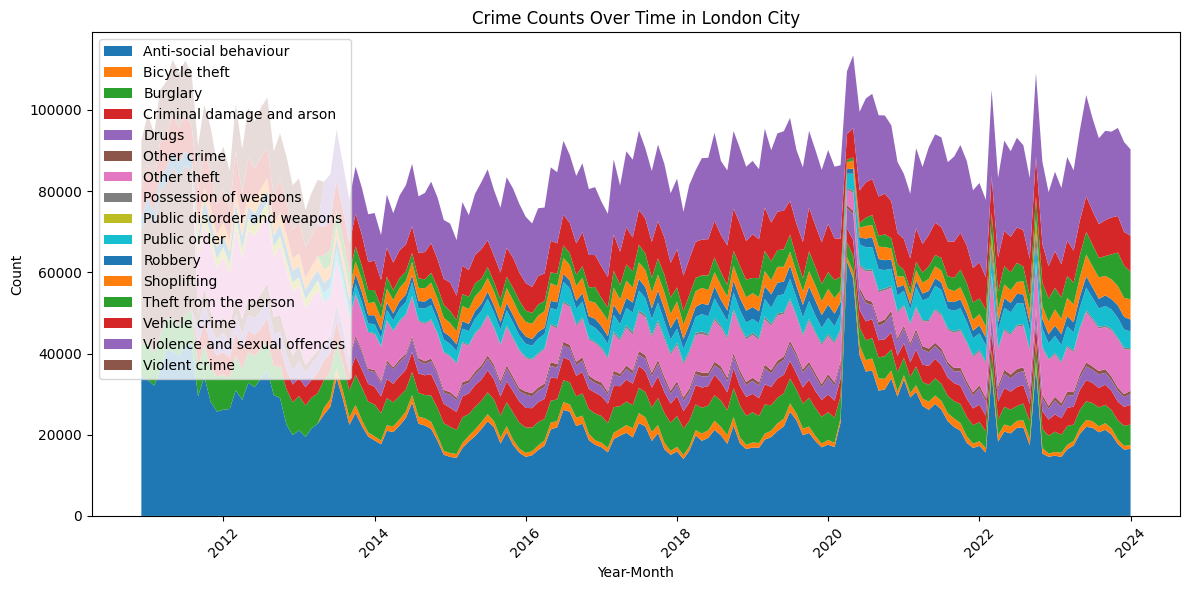

In [19]:
# Plotting total crime by crime
plotter(pivot_df, "London City")

In [20]:
# Grouping by total crime per quartile by borough
df_london = df2.groupby(['Borough', 'Year-Month']).size().to_frame('num_crimes').reset_index()
df_london

Borough  Year-Month  num_crimes
0     Barking and Dagenham  2010-12-01        2044
1     Barking and Dagenham  2011-01-01        2292
2     Barking and Dagenham  2011-02-01        2171
3     Barking and Dagenham  2011-03-01        2505
4     Barking and Dagenham  2011-04-01        2743
...                    ...         ...         ...
5051            Wandsworth  2023-09-01        2852
5052            Wandsworth  2023-10-01        3001
5053            Wandsworth  2023-11-01        2700
5054            Wandsworth  2023-12-01        2716
5055            Wandsworth  2024-01-01        2723

[5056 rows x 3 columns]

In [21]:
# Create the plot
fig = px.line(df_london, x='Year-Month', y='num_crimes', color='Borough',
              title='Number of Crimes per Borough Over Time')

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Crimes',
    legend_title='Borough',
    template='plotly_white',
    width=1200,
    height=800
)

# Show the plot
fig.show()

## EDA on a  Borough level + create R analysis file

Limit each dataframe to ``2021-03-01`` (underreporting's end) and ``2016-04-01`` (PAS' beginning).

In [22]:
df_pas2 = df_pas[(df_pas["Date"] <= dt.date(2021, 3, 1)) & (df_pas["Date"] >= dt.date(2015, 4, 1))]

df_pas2["Year-Month"] = pd.to_datetime( pd.DatetimeIndex(df_pas2.Date) + pd.DateOffset(1) ).date
df_pas2.drop("Date", inplace=True, axis=1)
df_pas2[df_pas2["Year-Month"] == dt.date(2015, 7, 1)]

Borough            Measure  Proportion  Year-Month
448  Barking and Dagenham   "Good Job" local        0.61  2015-07-01
449                Barnet   "Good Job" local        0.66  2015-07-01
450                Bexley   "Good Job" local        0.73  2015-07-01
451                 Brent   "Good Job" local        0.62  2015-07-01
452               Bromley   "Good Job" local        0.74  2015-07-01
..                    ...                ...         ...         ...
667                Sutton  Understand issues        0.80  2015-07-01
668         Tower Hamlets  Understand issues        0.73  2015-07-01
669        Waltham Forest  Understand issues        0.82  2015-07-01
670            Wandsworth  Understand issues        0.71  2015-07-01
671   City of Westminster  Understand issues        0.80  2015-07-01

[224 rows x 4 columns]

In [23]:
df_london2 = df_london[(df_london["Year-Month"] <= dt.date(2021, 3, 1)) & (df_london["Year-Month"] >= dt.date(2015, 4, 1))]
df_london2['Year-Month'] = pd.to_datetime(df_london2['Year-Month'])

# Change the time so the instances are quarterly
df_london2['Quarter'] = df_london2['Year-Month'].dt.to_period('Q').dt.start_time

df_quarterly = df_london2.groupby(['Quarter', 'Borough']).agg({'num_crimes': 'sum'}).reset_index()
df_quarterly.rename(columns={"Quarter": "Year-Month"}, inplace=True)
df_quarterly["Year-Month"] = pd.to_datetime(df_quarterly["Year-Month"]).dt.date

df_quarterly[df_quarterly["Year-Month"] == dt.date(2015, 7, 1)]

Year-Month                 Borough  num_crimes
32  2015-07-01    Barking and Dagenham        5701
33  2015-07-01                  Barnet        8182
34  2015-07-01                  Bexley        4064
35  2015-07-01                   Brent        8379
36  2015-07-01                 Bromley        6838
37  2015-07-01                  Camden        9305
38  2015-07-01     City of Westminster       15690
39  2015-07-01                 Croydon        9121
40  2015-07-01                  Ealing        9447
41  2015-07-01                 Enfield        7622
42  2015-07-01               Greenwich        7008
43  2015-07-01                 Hackney        9259
44  2015-07-01  Hammersmith and Fulham        6373
45  2015-07-01                Haringey        8409
46  2015-07-01                  Harrow        4348
47  2015-07-01                Havering        5338
48  2015-07-01              Hillingdon        8029
49  2015-07-01                Hounslow        7382
50  2015-07-01               Islington        8514
51  2015-07-01  Kensington and Chelsea        6507
52  2015-07-01    Kingston upon Thames        3480
53  2015-07-01                 Lambeth       11568
54  2015-07-01                Lewisham        8030
55  2015-07-01                  Merton        4140
56  2015-07-01                  Newham       10123
57  2015-07-01               Redbridge        6238
58  2015-07-01    Richmond upon Thames        3671
59  2015-07-01               Southwark        9764
60  2015-07-01                  Sutton        3202
61  2015-07-01           Tower Hamlets       11214
62  2015-07-01          Waltham Forest        7327
63  2015-07-01              Wandsworth        7213

In [24]:
df_ub['Year-Month'] = pd.to_datetime(df_ub['Year-Month'])

# Change the time so the instances are quarterly
df_ub['Quarter'] = df_ub['Year-Month'].dt.to_period('Q').dt.start_time

df_ub_quarter = df_ub.groupby(['Quarter', 'Borough']).agg({'Total_prop_no': 'sum', "no_count": 'sum', "total_count": 'sum'}).reset_index()
df_ub_quarter.rename(columns={"Quarter": "Year-Month"}, inplace=True)
df_ub_quarter["Year-Month"] = pd.to_datetime(df_ub_quarter["Year-Month"]).dt.date

df_ub_quarter[df_ub_quarter["Year-Month"] == dt.date(2015, 7, 1)]

Year-Month                 Borough  Total_prop_no  no_count  total_count
32  2015-07-01    Barking and Dagenham       0.000329         3           10
33  2015-07-01                  Barnet       0.000329         3           14
34  2015-07-01                  Bexley       0.000110         1            7
35  2015-07-01                   Brent       0.000329         3            9
36  2015-07-01                 Bromley       0.000219         2            3
37  2015-07-01                  Camden       0.000548         5           19
38  2015-07-01     City of Westminster       0.000219         2            6
39  2015-07-01                 Croydon       0.000657         6            9
40  2015-07-01                  Ealing       0.000329         3           12
41  2015-07-01                 Enfield       0.000329         3           11
42  2015-07-01               Greenwich       0.000438         4           11
43  2015-07-01                 Hackney       0.000219         2           19
44  2015-07-01  Hammersmith and Fulham       0.000329         3            6
45  2015-07-01                Haringey       0.000110         1            8
46  2015-07-01                  Harrow       0.000438         4           12
47  2015-07-01                Havering       0.000110         1            5
48  2015-07-01              Hillingdon       0.000329         3           12
49  2015-07-01                Hounslow       0.000438         4           11
50  2015-07-01               Islington       0.000438         4           10
51  2015-07-01  Kensington and Chelsea       0.000110         1           11
52  2015-07-01    Kingston upon Thames       0.000219         2            7
53  2015-07-01                 Lambeth       0.000329         3           10
54  2015-07-01                Lewisham       0.000329         3           13
55  2015-07-01                  Merton       0.000329         3            9
56  2015-07-01                  Newham       0.000438         4           12
57  2015-07-01               Redbridge       0.000219         2           11
58  2015-07-01    Richmond upon Thames       0.000986         9           15
59  2015-07-01               Southwark       0.000329         3           14
60  2015-07-01                  Sutton       0.000329         3            8
61  2015-07-01           Tower Hamlets       0.000110         1           10
62  2015-07-01          Waltham Forest       0.000548         5           13
63  2015-07-01              Wandsworth       0.000219         2            7

In [25]:
# Get unique combinations of 'Year-Month' and 'Borough'
unique_keys = pd.MultiIndex.from_product([
    pd.concat([df_pas2['Year-Month'], df_quarterly['Year-Month'], df_ub_quarter['Year-Month']]).unique(),
    pd.concat([df_pas2['Borough'], df_quarterly['Borough'], df_ub_quarter['Borough']]).unique()
], names=['Year-Month', 'Borough'])

cartesian_product_df = pd.DataFrame(index=unique_keys).reset_index()

# Merge each DataFrame with the cartesian product
merged_df0 = cartesian_product_df.merge(df_pas2, on=['Year-Month', 'Borough'], how='left')
merged_df1 = merged_df0.merge(df_quarterly, on=['Year-Month', 'Borough'], how='left')
merged_df = merged_df1.merge(df_ub_quarter, on=['Year-Month', 'Borough'], how='left')

# Limit timeframe
merged_df2 = merged_df[(merged_df["Year-Month"] <= dt.date(2021, 3, 1)) & (merged_df["Year-Month"] >= dt.date(2016, 4, 1))]

# For those with no underreporting values, fill in zeroes
merged_df2[["Total_prop_no", "no_count", "total_count"]] = merged_df2[["Total_prop_no", "no_count", "total_count"]].fillna(0)

In [26]:
print(merged_df2)

      Year-Month               Borough                Measure  Proportion  \
672   2016-04-01  Barking and Dagenham       "Good Job" local        0.68   
673   2016-04-01  Barking and Dagenham   Contact ward officer        0.32   
674   2016-04-01  Barking and Dagenham         Informed local        0.43   
675   2016-04-01  Barking and Dagenham     Listen to concerns        0.76   
676   2016-04-01  Barking and Dagenham  Relied on to be there        0.74   
...          ...                   ...                    ...         ...   
5787  2021-01-01   City of Westminster     Listen to concerns        0.70   
5788  2021-01-01   City of Westminster  Relied on to be there        0.67   
5789  2021-01-01   City of Westminster  Treat everyone fairly        0.71   
5790  2021-01-01   City of Westminster      Understand issues        0.68   
5791  2021-01-01   City of Westminster              Trust MPS        0.84   

      num_crimes  Total_prop_no  no_count  total_count  
672         5831  

In [27]:
# Create a pivot table with Year-Month and Borough as index and Measures as columns
pivot_df = merged_df2.pivot_table(index=['Year-Month', 'Borough'], columns='Measure', values='Proportion').reset_index()

# Rename the columns to avoid MultiIndex
pivot_df.columns.name = None

# Merge the pivot table back with the original dataframe to include other columns
result_df = merged_df2.drop(columns=['Measure', 'Proportion']).drop_duplicates()
result_df = result_df.merge(pivot_df, on=['Year-Month', 'Borough'], how='left')
result_df = result_df.rename(columns={"\"Good Job\" local": "Good.job.local", "Contact ward officer": "Contact.ward.officer", 
                                      "Informed local": "Informed.local", "Listen to concerns": "Listen.to.concerns", "Relied on to be there": "Relied.on.to.be.there", "Treat everyone fairly": "Treat.everyone.fairly", 
                                      "Trust MPS": "Trust.MPS", "Understand issues": "Understand.issues"})
result_df

Year-Month               Borough  num_crimes  Total_prop_no  no_count  \
0    2016-04-01  Barking and Dagenham        5831       0.000110       1.0   
1    2016-04-01                Barnet        8569       0.000876       8.0   
2    2016-04-01                Bexley        4080       0.000329       3.0   
3    2016-04-01                 Brent        9306       0.000438       4.0   
4    2016-04-01               Bromley        6483       0.000110       1.0   
..          ...                   ...         ...            ...       ...   
635  2021-01-01                Sutton        3951       0.000219       2.0   
636  2021-01-01         Tower Hamlets       12433       0.000657       6.0   
637  2021-01-01        Waltham Forest        7830       0.000219       2.0   
638  2021-01-01            Wandsworth        9023       0.000767       7.0   
639  2021-01-01   City of Westminster       10421       0.000657       6.0   

     total_count  Good.job.local  Contact.ward.officer  Informed.local  \
0            8.0            0.68                  0.32            0.43   
1           21.0            0.67                  0.36            0.41   
2            9.0            0.76                  0.28            0.53   
3           13.0            0.63                  0.46            0.42   
4            5.0            0.70                  0.29            0.50   
..           ...             ...                   ...             ...   
635          9.0            0.64                  0.28            0.47   
636         15.0            0.46                  0.14            0.35   
637         18.0            0.55                  0.25            0.42   
638         13.0            0.57                  0.18            0.42   
639         15.0            0.58                  0.22            0.43   

     Listen.to.concerns  Relied.on.to.be.there  Treat.everyone.fairly  \
0                  0.76                   0.74                   0.77   
1                  0.74                   0.77                   0.84   
2                  0.75                   0.81                   0.79   
3                  0.66                   0.74                   0.68   
4                  0.75                   0.77                   0.80   
..                  ...                    ...                    ...   
635                0.75                   0.74                   0.80   
636                0.65                   0.65                   0.68   
637                0.66                   0.64                   0.67   
638                0.72                   0.68                   0.70   
639                0.70                   0.67                   0.71   

     Trust.MPS  Understand.issues  
0         0.83               0.72  
1         0.87               0.67  
2         0.90               0.73  
3         0.83               0.66  
4         0.88               0.70  
..         ...                ...  
635       0.86               0.75  
636       0.83               0.62  
637       0.79               0.62  
638       0.79               0.70  
639       0.84               0.68  

[640 rows x 14 columns]

In [28]:
736/32  # num different dates

23.0

In [29]:
# Save pickle -- df with dummy var for R
# result_df.to_pickle(r"result_df.pkl")
result_df.to_csv(r"result_df.csv")


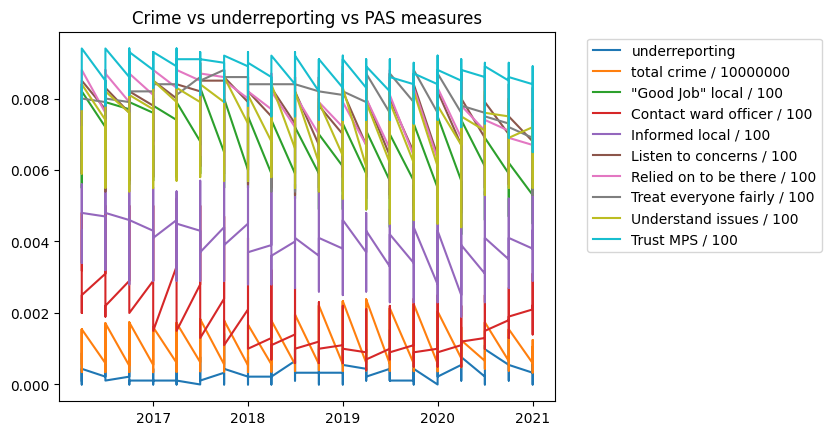

In [30]:
# Plotting total underreporting vs crime vs PAS
df_plot = merged_df2.copy()
df_plot["Crime / 10000000"] = df_plot["num_crimes"] / 10000000

plt.plot(df_plot["Year-Month"], df_plot["Total_prop_no"], label="underreporting")
plt.plot(df_plot["Year-Month"], df_plot["Crime / 10000000"], label="total crime / 10000000")

for measure in df_plot["Measure"].unique():
    df_measure = df_plot[df_plot["Measure"] == measure]
    df_measure[f"{measure} / 100"] = df_measure["Proportion"] / 100
    plt.plot(df_measure["Year-Month"], df_measure[f"{measure} / 100"], label=f"{measure} / 100")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title("Crime vs underreporting vs PAS measures")
plt.show()

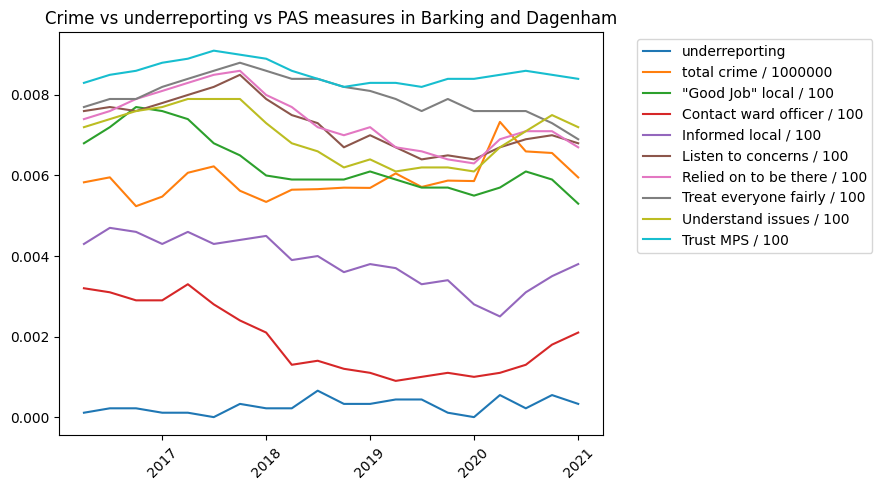

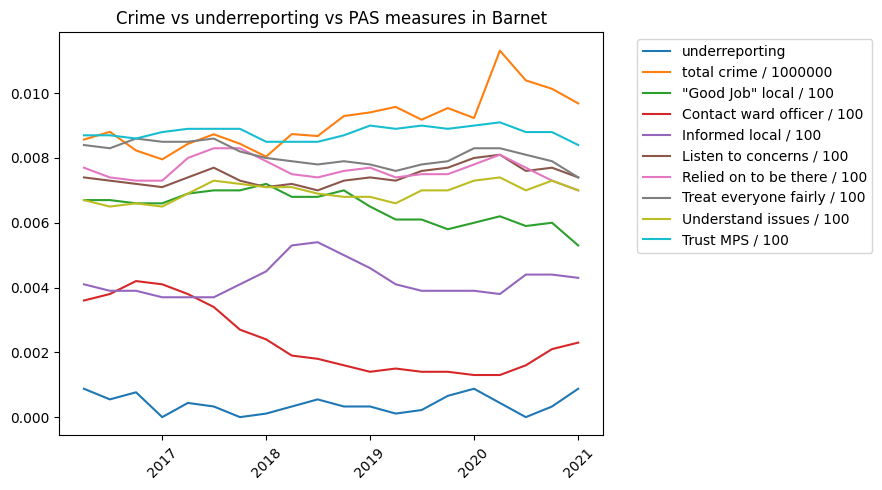

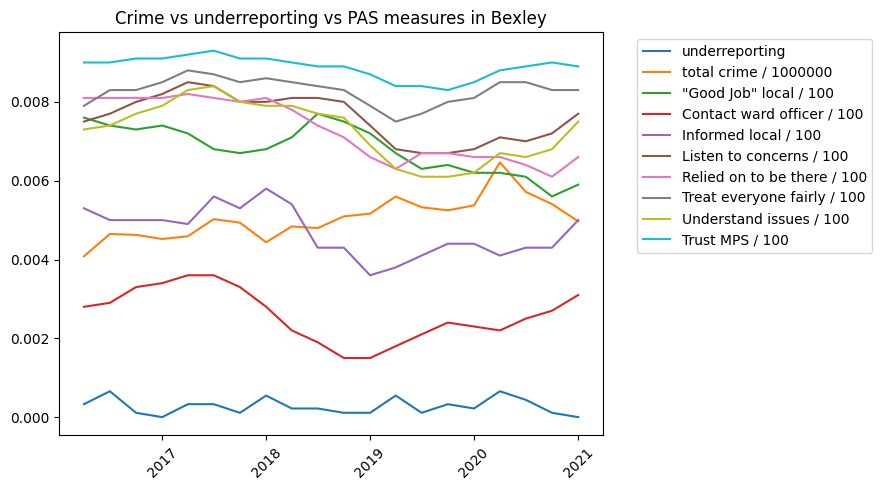

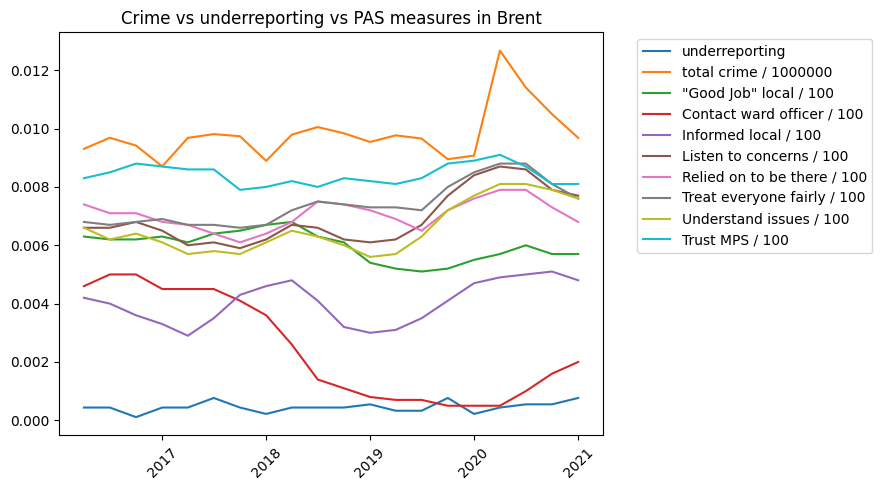

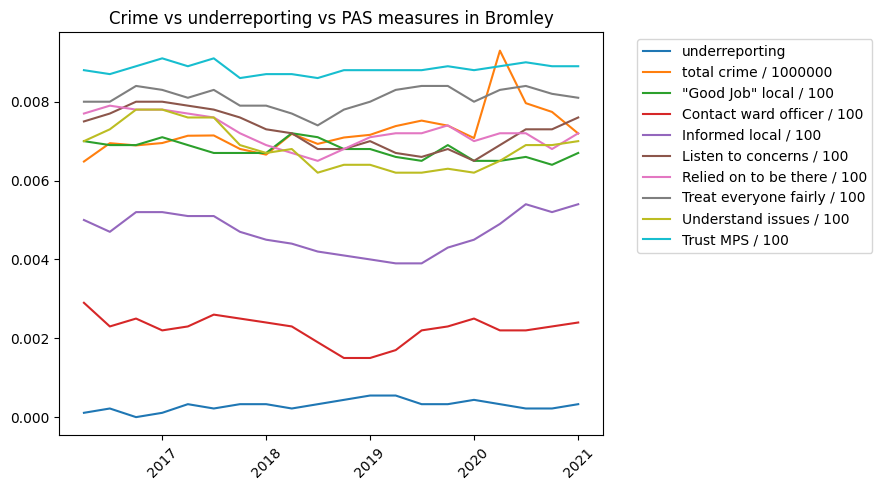

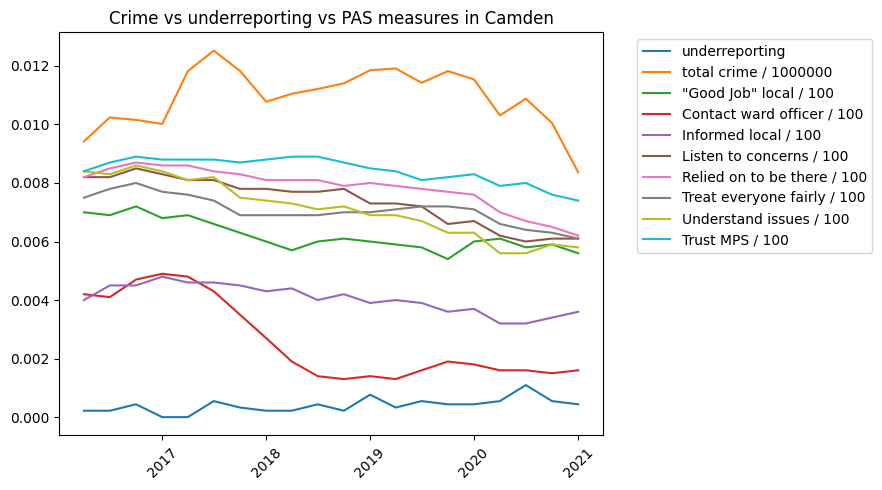

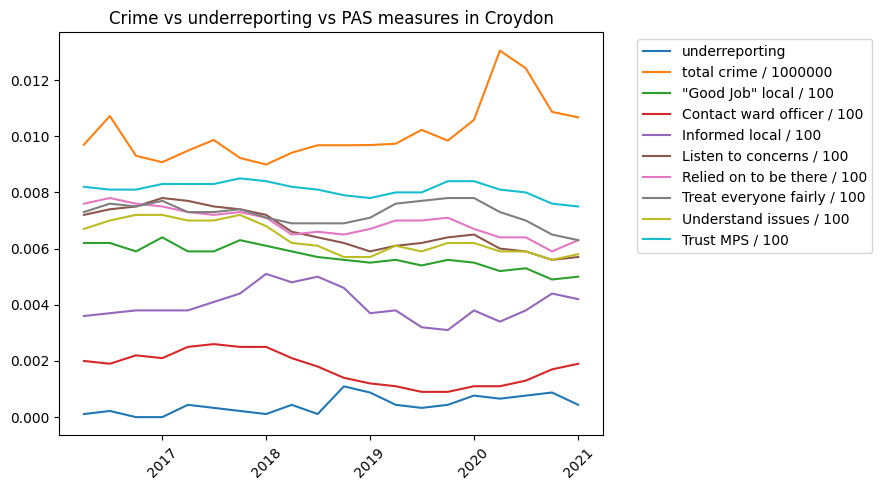

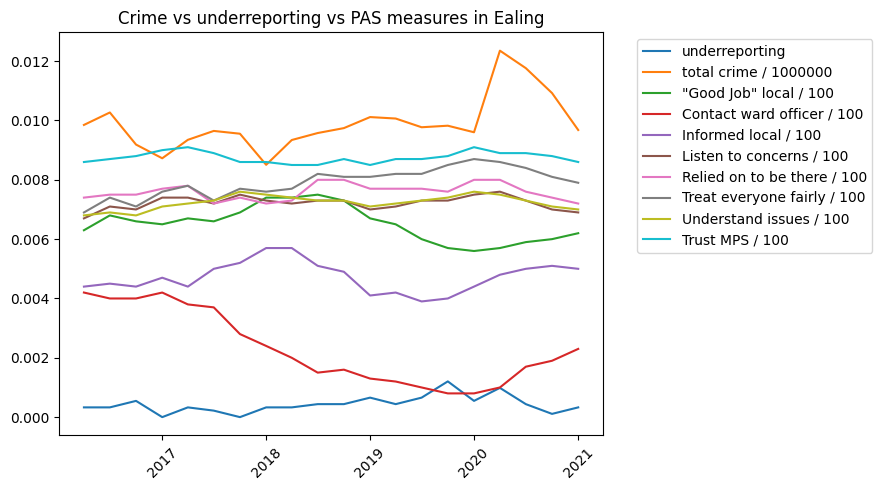

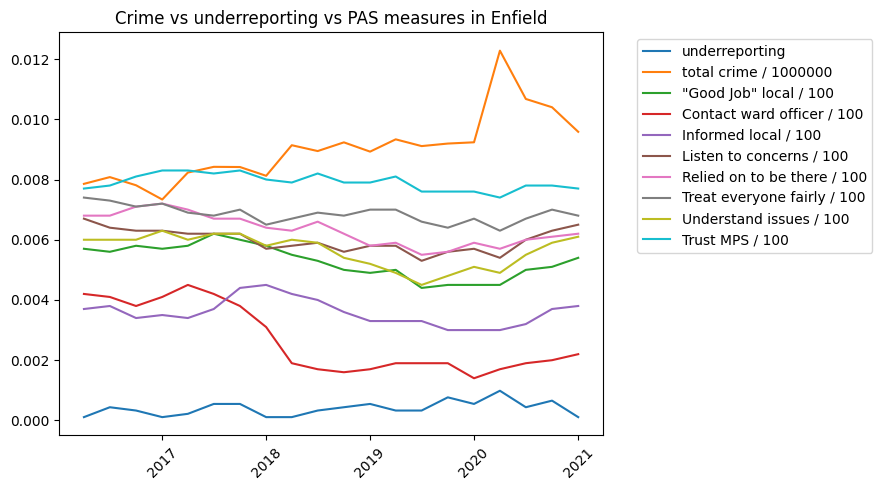

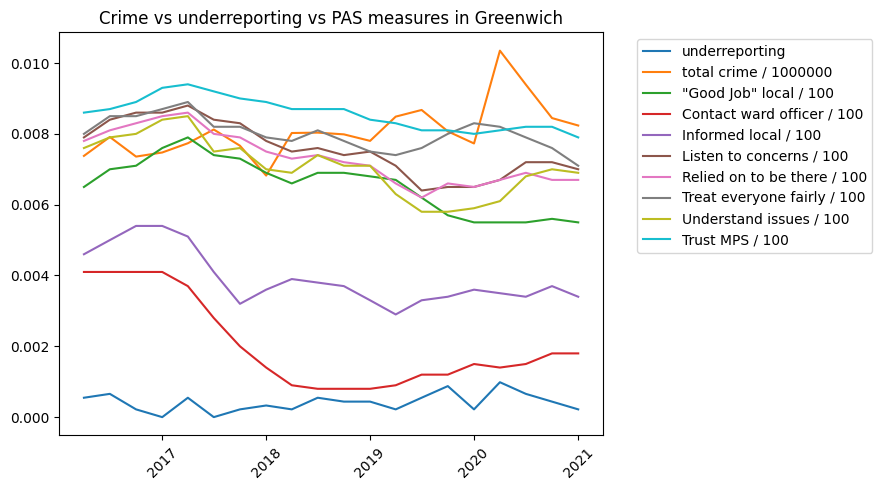

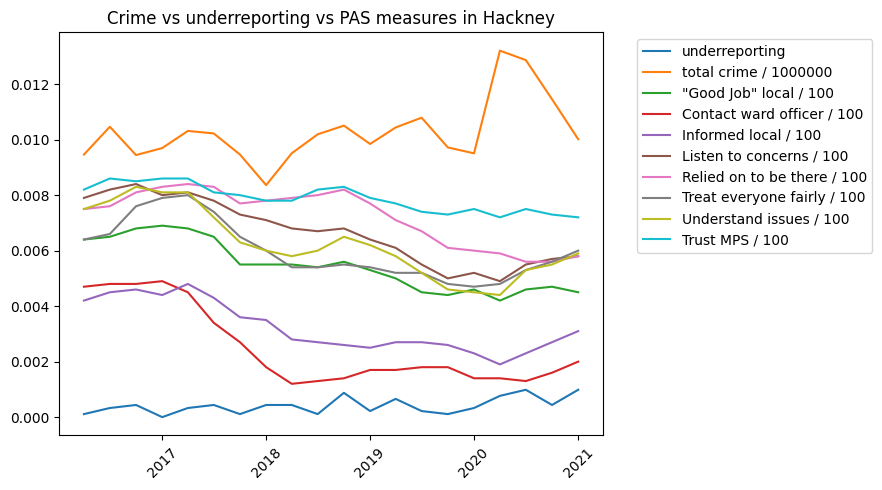

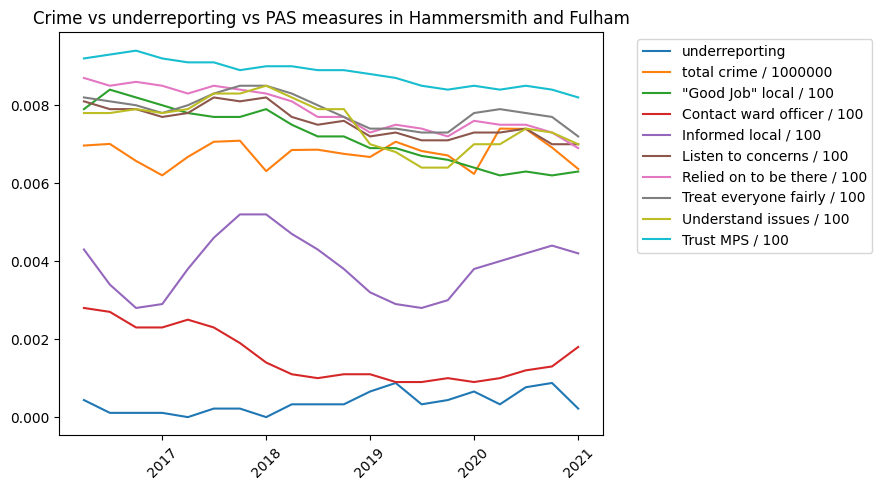

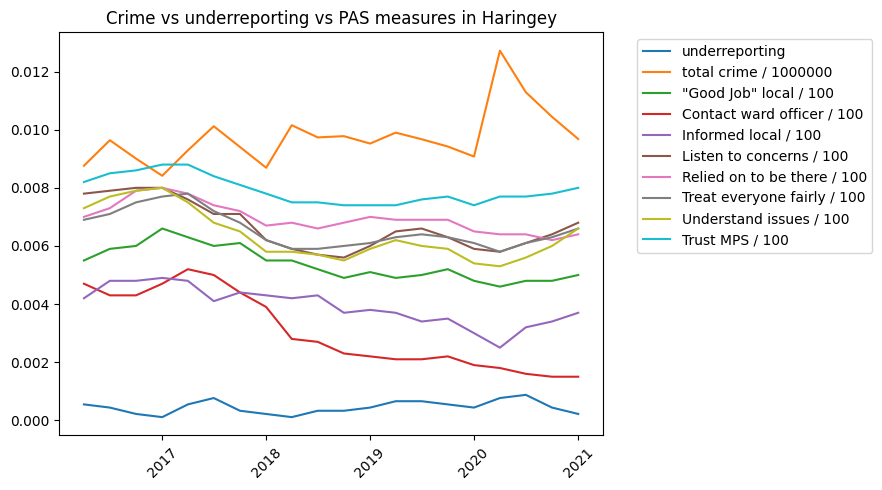

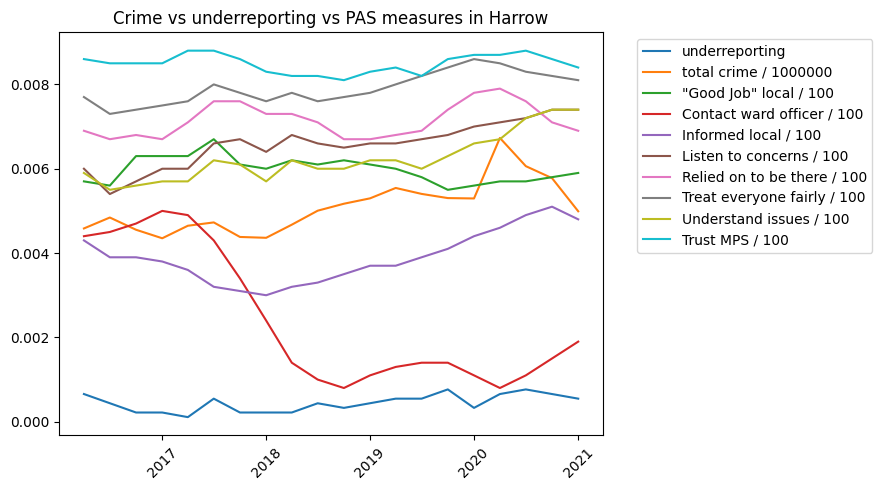

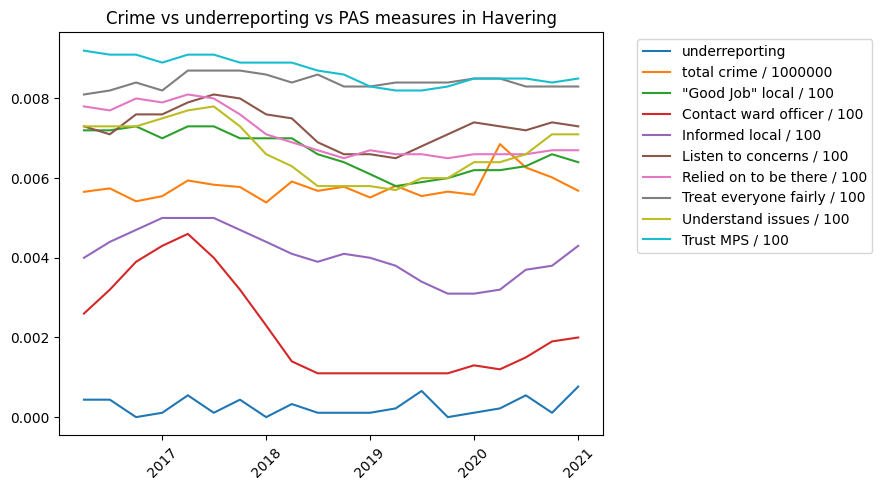

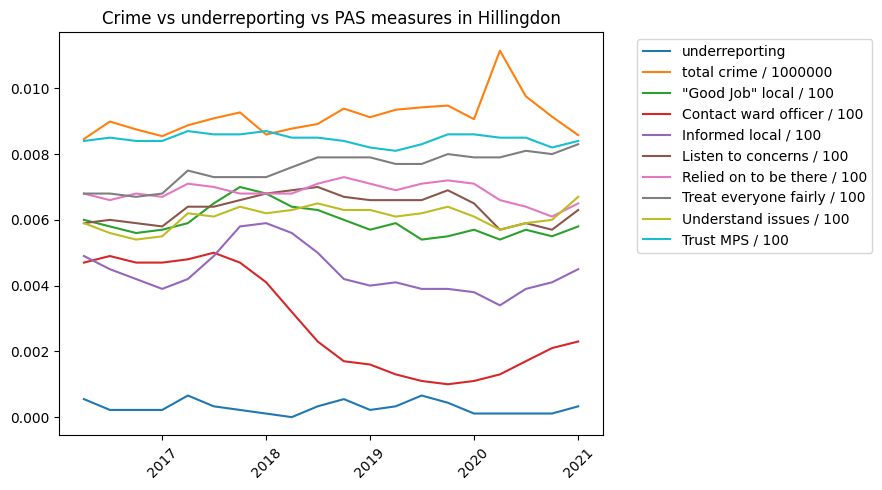

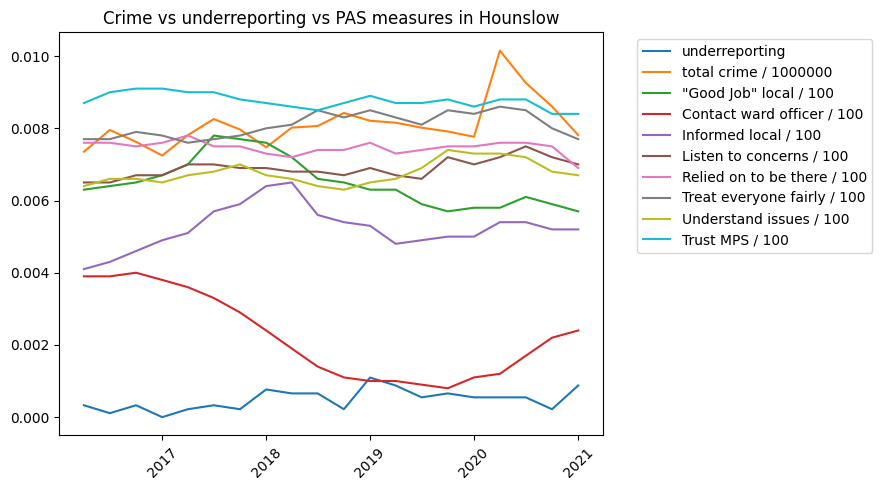

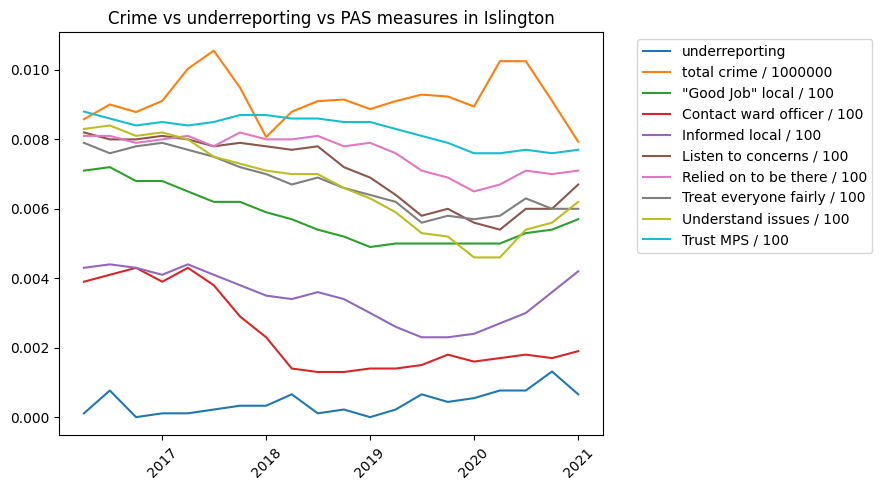

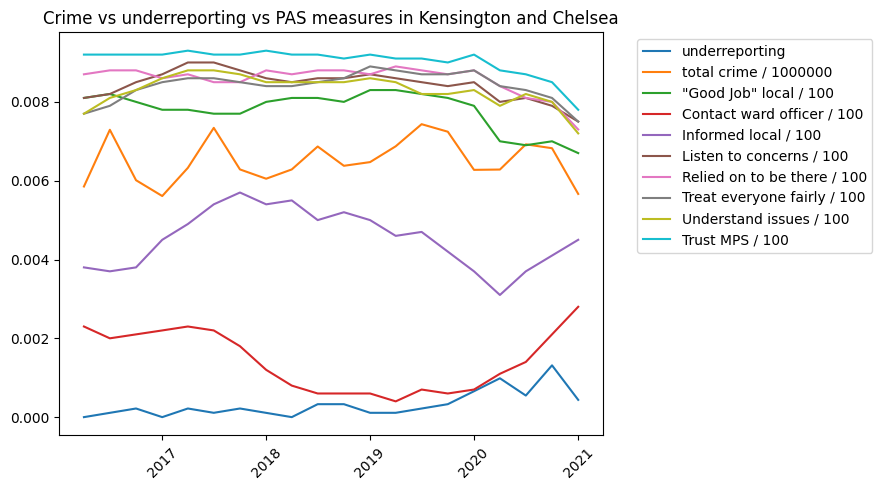

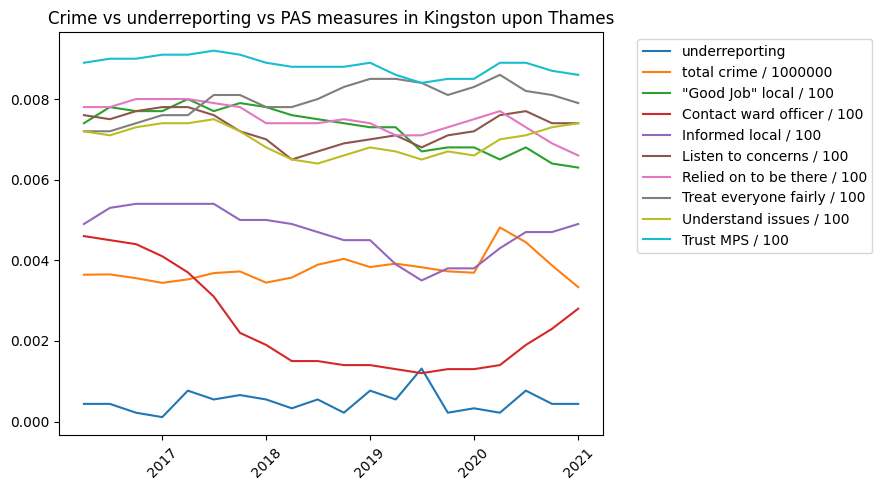

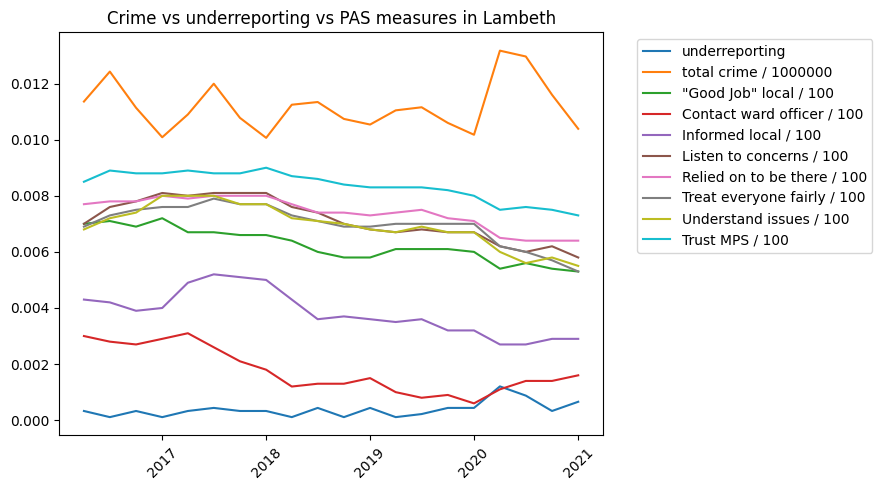

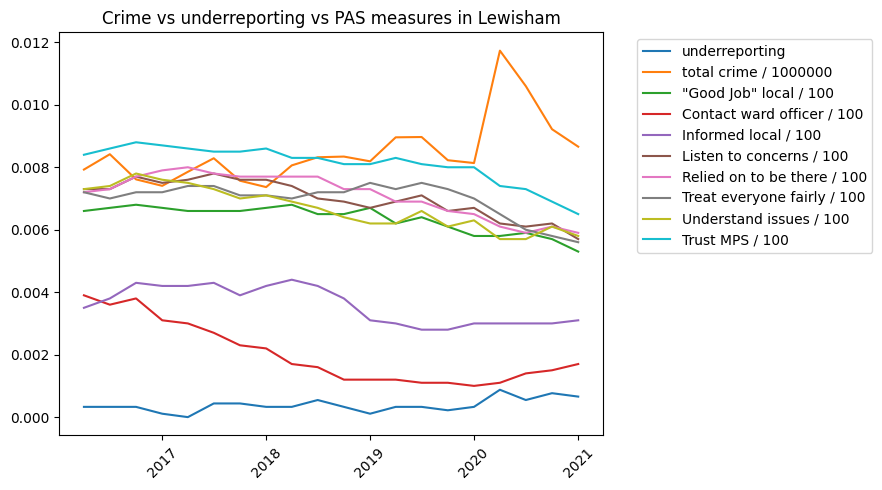

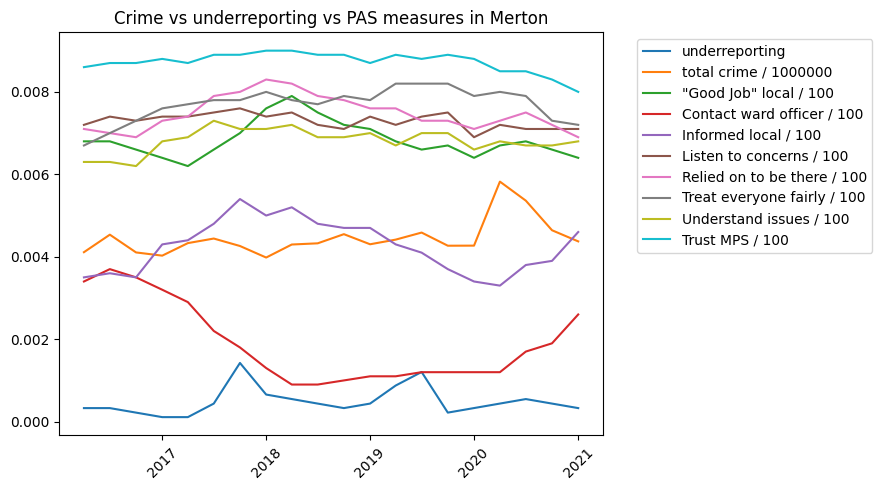

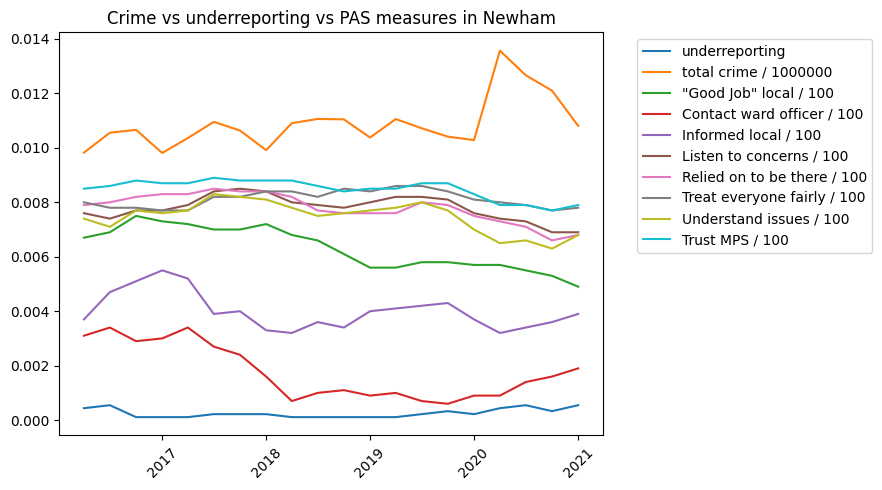

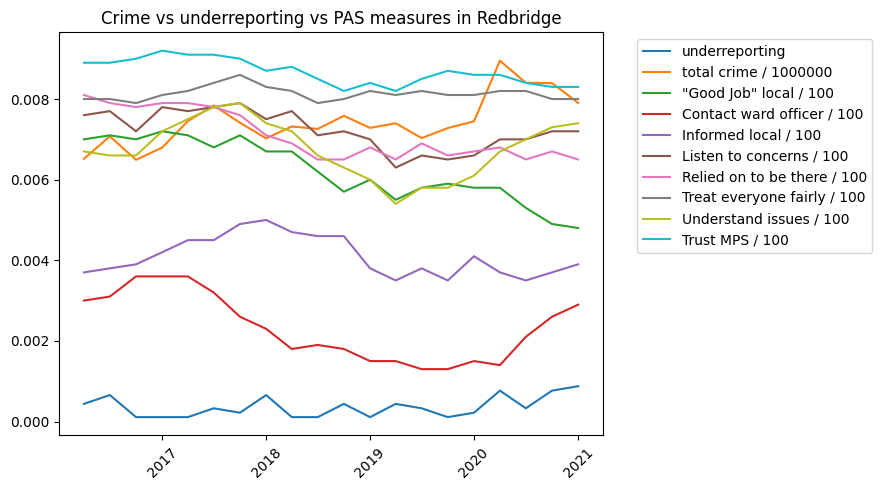

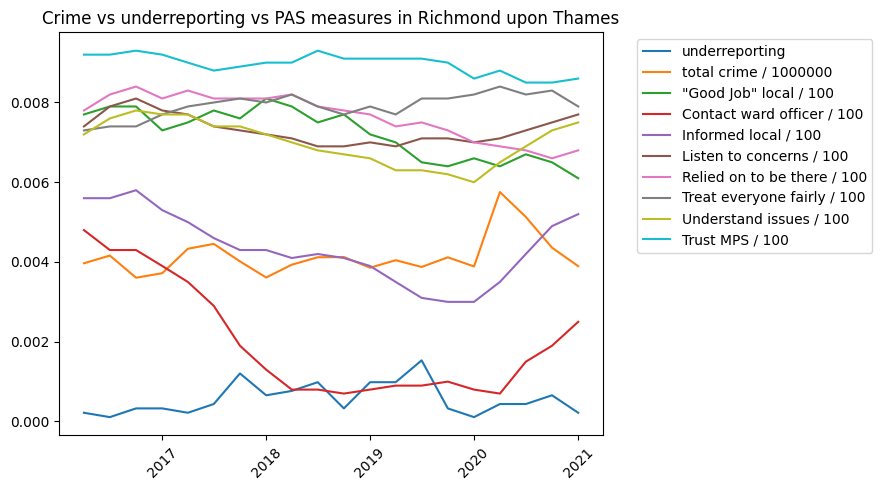

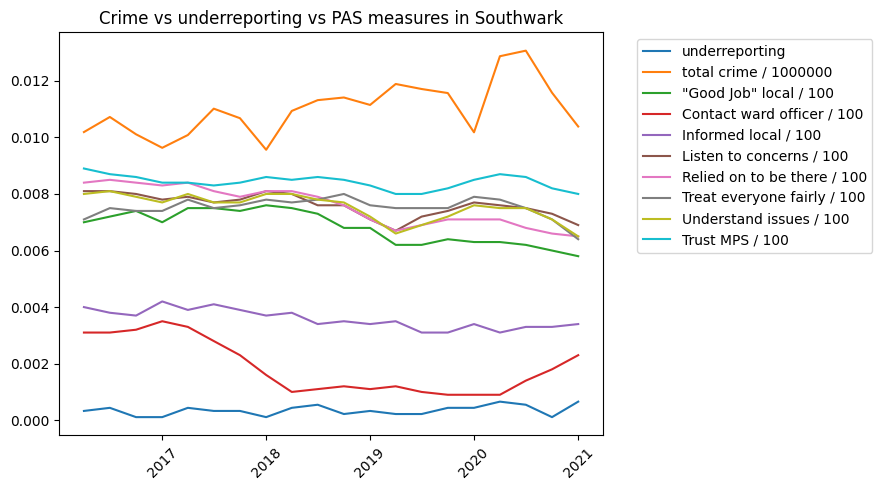

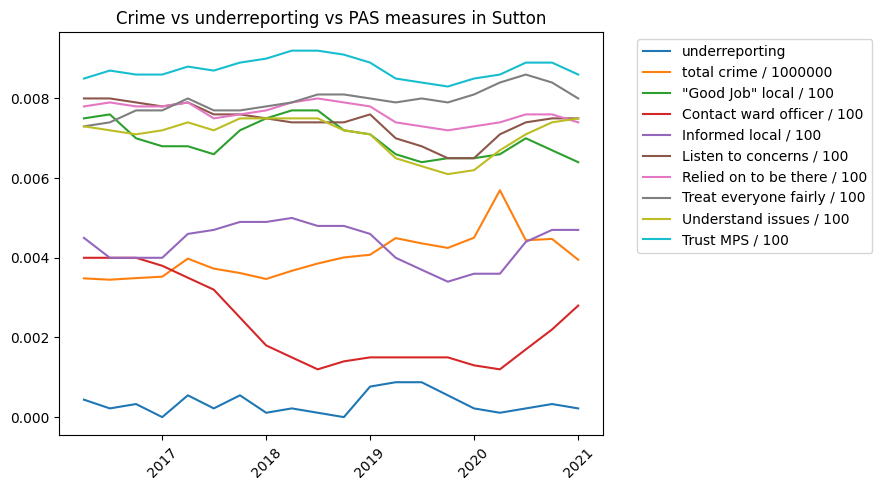

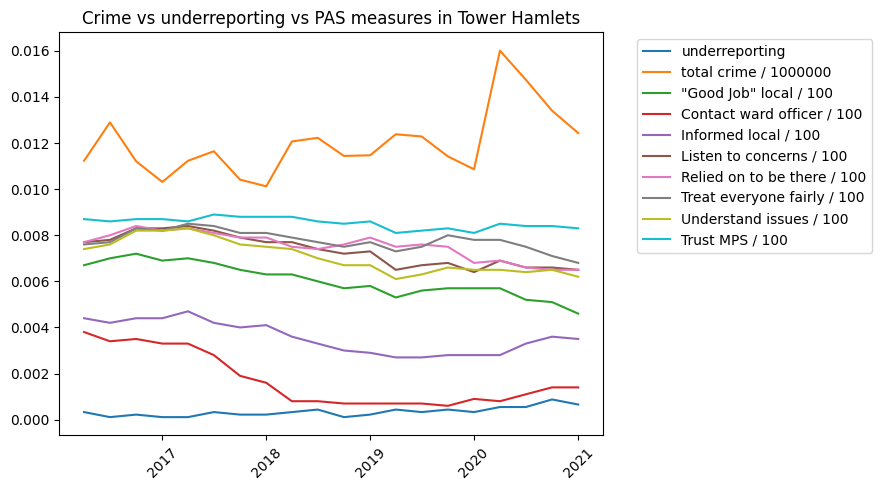

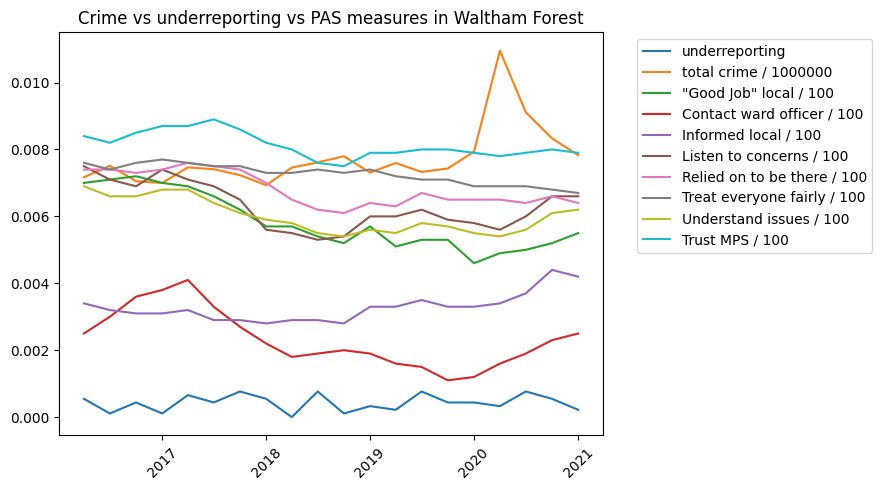

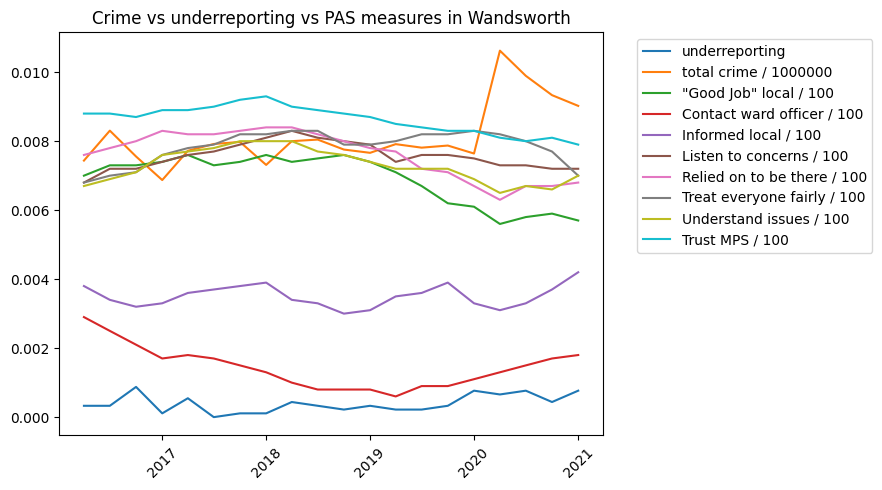

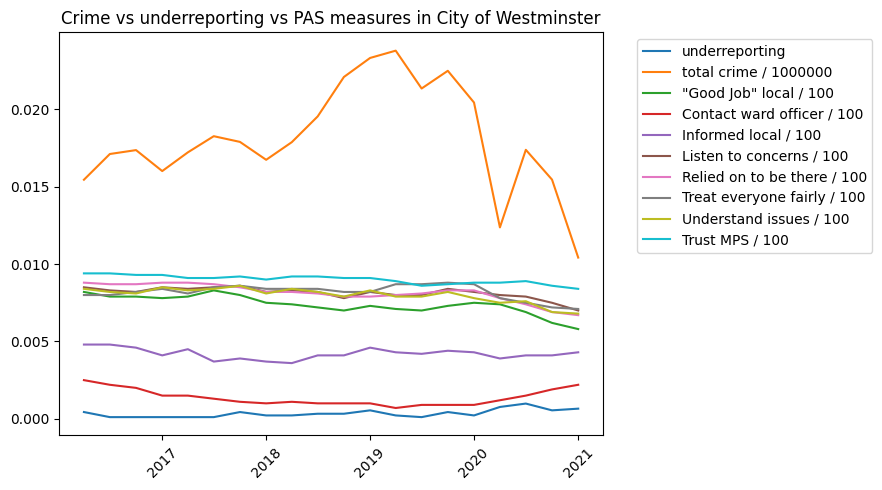

In [31]:
# Iterate over unique boroughs
for B in df_plot["Borough"].unique():
    df_plot2 = df_plot[df_plot["Borough"] == B]
    df_plot2["Crime / 1000000"] = df_plot2["num_crimes"] / 1000000
    
    # Plotting
    plt.figure(figsize=(9,5))
    plt.plot(df_plot2["Year-Month"], df_plot2["Total_prop_no"], label="underreporting")
    plt.plot(df_plot2["Year-Month"], df_plot2["Crime / 1000000"], label="total crime / 1000000")
    
    for measure in df_plot2["Measure"].unique():
        df_measure = df_plot2[df_plot2["Measure"] == measure]
        df_measure[f"{measure} / 100"] = df_measure["Proportion"] / 100
        plt.plot(df_measure["Year-Month"], df_measure[f"{measure} / 100"], label=f"{measure} / 100")
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title(f"Crime vs underreporting vs PAS measures in {B}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()